<a href="https://colab.research.google.com/github/hoihui/pkgs/blob/master/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

In [2]:
# !pip3 install -U torch torchvision
import torch
cuda=torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
torch.__version__, cuda

('1.1.0', True)

# Torch

https://classroom.udacity.com/courses/ud188/lessons/c1541fd7-e6ec-4177-a5b1-c06f1ce09dd8/concepts/558e6218-96dc-47e2-85cd-9c779a263fb3

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/style-transfer/Style_Transfer_Solution.ipynb

1. Use VGG19 to extract style from a **style image**
2. Use VGG19 to extract content from a **content image**
3. Minimize the combined **style loss** and **content loss** on the target(output) image.
4. Adjust the ration of the two losses to get desired output

## Load VGG19 and Images

In [3]:
from torchvision import models
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

vgg.to(device);

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:07<00:00, 78756601.81it/s]


In [0]:
from torchvision import transforms
from io import BytesIO
import requests
style='https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Tsunami_by_hokusai_19th_century.jpg/2880px-Tsunami_by_hokusai_19th_century.jpg'
content='https://www.collegemagazine.com/wp-content/uploads/2014/09/odk-fountain.jpg'

style = Image.open(BytesIO(requests.get(style).content)).convert('RGB')
content = Image.open(BytesIO(requests.get(content).content)).convert('RGB')

in_transform = transforms.Compose([transforms.Resize(400),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.485, 0.456, 0.406), 
                                                        (0.229, 0.224, 0.225))])

style = in_transform(style)[:3,:,:].unsqueeze(0).to(device)
content = in_transform(content)[:3,:,:].unsqueeze(0).to(device)

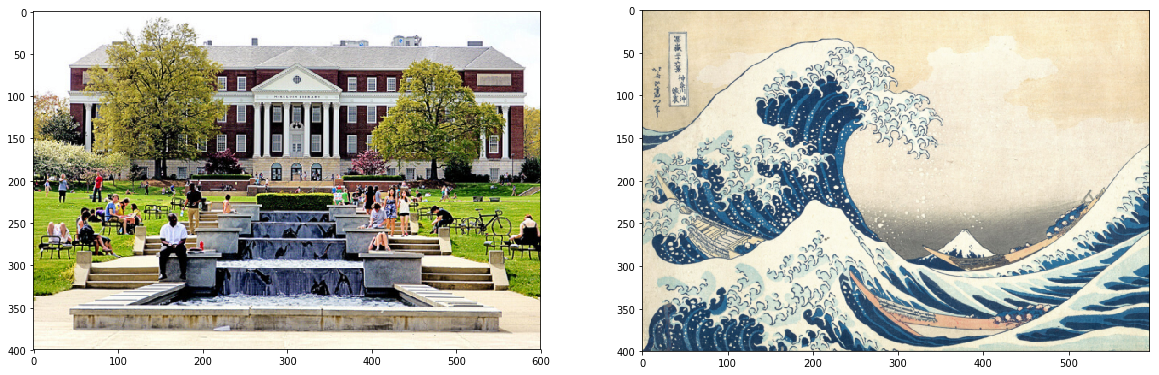

In [5]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
def im_convert(tensor):    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

## Extracting style/content features from vgg

layers to use are from Gatys et al (2016):

In [0]:
layernames = ['0','5','10','19','21','28']  # 21 is content representation
def get_features(x, model=vgg):        
    features = []
    for name, layer in model._modules.items():  #pass through the OrderedDict
        x = layer(x)
        if name in layernames:
            features.append(x)            
    return features

content_features=get_features(content)
style_features=get_features(style)

Compute gram matrix for summary of style:

In [0]:
def gram_matrix(tensor):# https://en.wikipedia.org/wiki/Gramian_matrix
    _, d, h, w = tensor.size()  #batch_size, depth, height, and width
    tensor = tensor.view(d, h * w)
    return torch.mm(tensor, tensor.t())

style_grams = [ gram_matrix(style_feature) for style_feature in style_features ]

In [0]:
# start off the target as a copy of *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

## Defining and Optimizing wrt Loss function

In [0]:
import torch.optim as optim
style_weights = [1.,0.75,0.2, 0.2,0,0.2]  #corresponds to variable layers
content_weight = 1 
style_weight = 5e6

optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # how many steps
show_every = 400

for ii in range(1, steps+1):
    
    target_features = get_features(target)
    content_loss = torch.mean((target_features[4] - content_features[4])**2)
    
    # computing style loss
    style_loss = 0
    for layerid in range(len(style_weights)):
        target_feature = target_features[layerid]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layerid]
        layer_style_loss = style_weights[layerid] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
        
    # total loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Final Display

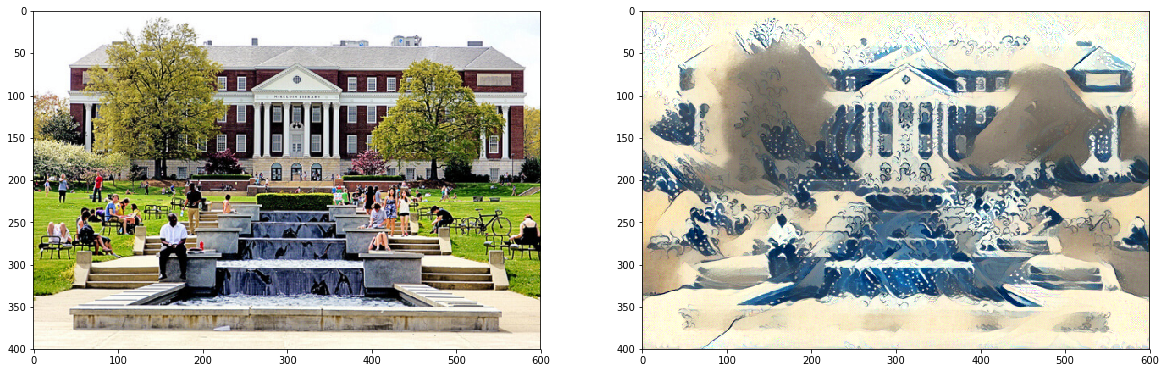

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))